In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import clustering_based_anomaly_detection as clustering
import GMM_based_anomaly_detection as gmm
import sketch_based_anomaly_detection as sketch
import simple_classifier_utils
import utilies
from IPython.display import HTML, display
from tabulate import tabulate

Загружаем тестовые данные. В данном примере были отобраны тестовые данные трафика netflow за неделю.

In [2]:
ES_DATA_PATH = 'dataset/'
ES_DATA_FILE = '2022-04-06_day'
df = pd.read_csv(ES_DATA_PATH + ES_DATA_FILE + '.csv', index_col=0)
private_ip_set = utilies.get_private_ips(df)
df.timestamp = pd.to_datetime(df.timestamp)

Пример формата входных данных:

In [3]:
df.head()

,timestamp,in_bytes,ipv4_src,ipv4_dst,in_pkts,l4_src_port,l4_dst_port,ip_protocol_version,protocol
0,2022-04-06 00:00:00+00:00,636,92.50.154.90,224.0.0.252,12,64635,5355,4,17
1,2022-04-06 00:00:00+00:00,13227,10.0.109.16,10.0.26.100,65,50416,389,4,6
2,2022-04-06 00:00:00+00:00,17983,10.0.109.1,10.0.109.184,34,55777,56522,4,17
3,2022-04-06 00:00:00+00:00,33493,10.0.109.75,10.0.109.1,72,51850,55777,4,17
4,2022-04-06 00:00:00+00:00,108,10.0.109.152,91.244.183.103,1,55777,55777,4,17


Количество данных:

In [4]:
len(df)

4701867

# Поиск аномалий

Поиск аномалий алгоритмом DBSCAN - пространственная кластеризация, входные данные - количество трафика

In [5]:
%%time
eps = 10
min_samples = 20
strategy='concatenate'
DBSCAN_series = clustering.process_data(df, private_ip_set, strategy, eps, min_samples)

CPU times: total: 8.42 s
Wall time: 8.42 s


In [6]:
utilies.print_anomalies(DBSCAN_series)

Anomalies: 64 Aggregated by hour data: 4176
Unique IPs: 5


Поиск аномалий алгоритмом LOF - локальный уровень выброса (по-сути K-mins), входные данные - количество трафика

In [7]:
%%time
n_neighbors = len(df) / 10
LOF_series = simple_classifier_utils.process_data(df, n_neighbors)

CPU times: total: 8.52 s
Wall time: 8.5 s


In [8]:
utilies.print_anomalies(LOF_series)

Anomalies: 1037 Aggregated by hour data: 4176
Unique IPs: 133


Поиск аномалий с помощью модели смешанного гауссова узла GMM:

In [9]:
%%time
n_components = 1
n_init = 100
random_state = 40
treshold = 3
strategy='concatenate'
gmm_series = gmm.process_data(df, private_ip_set, strategy, treshold, n_components, n_init, random_state)

CPU times: total: 1min 52s
Wall time: 17.8 s


In [10]:
utilies.print_anomalies(gmm_series)

Anomalies: 216 Aggregated by hour data: 4176
Unique IPs: 32


# Результат работы ансамбля алгоритмов

DBSCAN + LOF:

In [11]:
utilies.print_anomalies(DBSCAN_series, LOF_series)

Anomalies: 8 Aggregated by hour data: 8352
Unique IPs: 3


C:\Users\osenenko.ale\Documents\Projects\NetFlow\utilies.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x = x * args[0]


DBSCAN + GMM:

In [12]:
utilies.print_anomalies(DBSCAN_series, gmm_series)

Anomalies: 53 Aggregated by hour data: 4176
Unique IPs: 5


LOF + GMM:

In [13]:
utilies.print_anomalies(LOF_series, gmm_series)

Anomalies: 144 Aggregated by hour data: 8352
Unique IPs: 26


C:\Users\osenenko.ale\Documents\Projects\NetFlow\utilies.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x = x * args[0]


Визуализация аномалий алгоритма DBSCAN трафика за неделю с помощью t-SNE ( t-распределенное стохастическое соседнее вложение для неаномального и аномального трафика):

anomalies: ['10.0.109.125' '10.0.109.1' '10.0.109.16' '10.0.159.5']


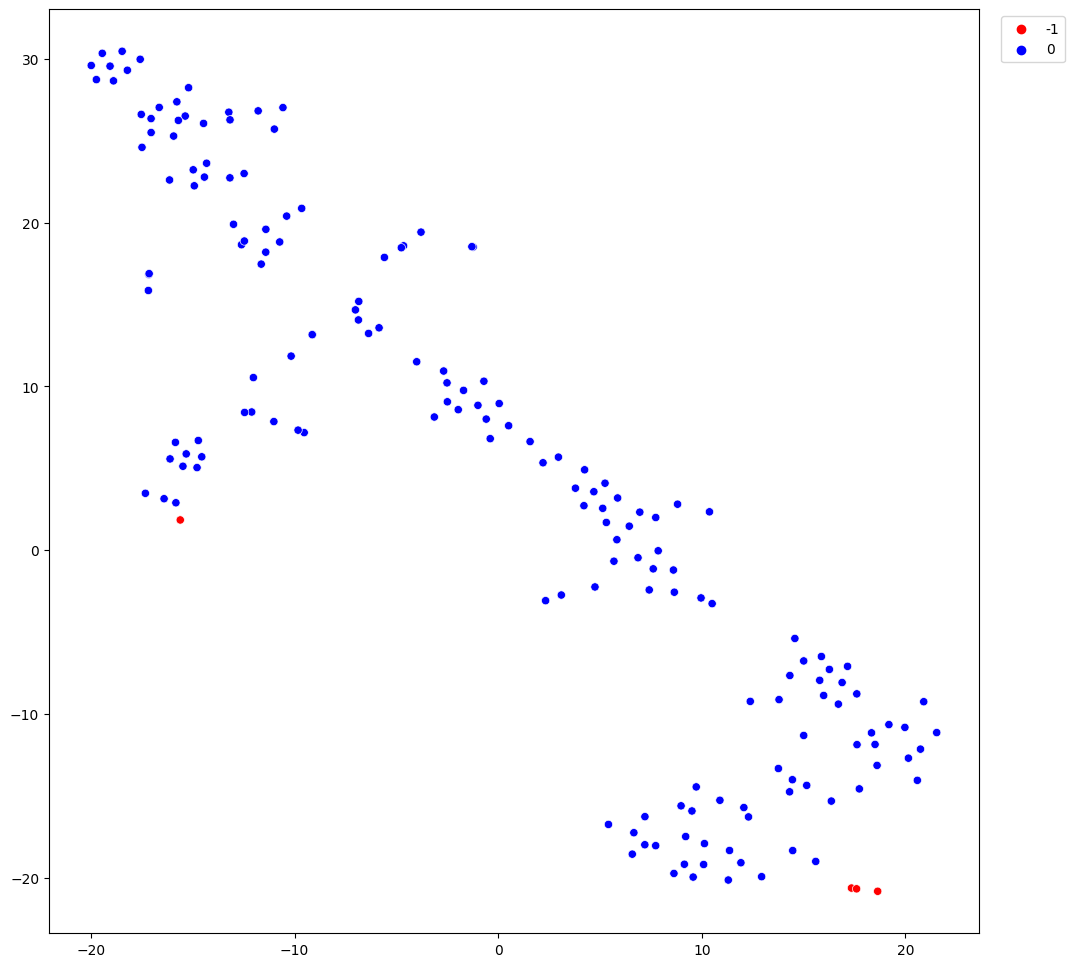

In [14]:
clustering.tsne_visualization(df, private_ip_set, strategy='concatenate', eps=5, min_samples=10)